### Import necessary libraries

In [29]:
import pandas as pd
import numpy as np
import h2o 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve 
from sklearn.calibration import calibration_curve
import os

In [30]:
import pickle

# CREATE EXPLANATIONS FOR RANDOM FOREST 
**File**: 5_explanation_alibi.ipynb

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-28

**Data**: train and test (same as evaluated model) 


## Modify

**Working directory**

In [31]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")
overwrite = False

**Parameters & Settings**

In [32]:
target = 'HC_Patient_Next_Year'
excluded = 'Total_Costs_Next_Year'

### Load data

In [33]:
train = pd.read_csv('data/train_validate.csv', sep=',', header=0)
test = pd.read_csv('data/test.csv', sep=',', header=0)

### Transform categorical values

In [34]:
# train['Sex'] = pd.factorize(train['Sex'])[0]
# test['Sex'] = pd.factorize(test['Sex'])[0]
# train['HC_Patient'] = pd.factorize(train['HC_Patient'])[0]
# test['HC_Patient'] = pd.factorize(test['HC_Patient'])[0]
# train['HC_Patient_Next_Year'] = pd.factorize(train['HC_Patient_Next_Year'])[0]
# test['HC_Patient_Next_Year'] = pd.factorize(test['HC_Patient_Next_Year'])[0]

#TODO: Check if I really need this encoding (for alibi pdp plot)
from sklearn.preprocessing import OrdinalEncoder
all_columns = train.columns
# categorical_columns = ['Sex', 'HC_Patient']

# is_str = train.dtypes == str
# min_val = train.max(axis=0)
# max_val = train.min(axis=0)

# If a column has more than two values, it is not categorical
categorical_columns = all_columns[train.nunique(axis=0) == 2]
numerical_columns = [all_columns.difference(categorical_columns)]

categorical_columns_indices = [test.columns.tolist().index(cn) for cn in categorical_columns]
oe = OrdinalEncoder().fit(train[categorical_columns])
categorical_name_mapping = {i: list(v) if i < 11 else ['diagnosis absent', 'diagnosis present']
                            for (i, v) in zip(categorical_columns_indices, oe.categories_)}


train.loc[:, categorical_columns] = oe.transform(train[categorical_columns])
test.loc[:, categorical_columns] = oe.transform(test[categorical_columns])

### Create train & test data set

In [35]:
predictors = [var for var in train.columns if var not in (target, excluded)]
X_train, y_train = train[predictors], train[target]
X_test, y_test = test[predictors], test[target]

In [36]:
train.head()

,HC_Patient_Next_Year,Total_Costs_Next_Year,HC_Patient,Sex,Age,Need_of_Care_Duration,DMP_Duration,Total_Costs,Inpatient_Num_Diagnoses,Outpatient_Num_Diagnoses,...,Prescription_S03,Prescription_V01,Prescription_V03,Prescription_V04,Prescription_V06,Prescription_V07,Prescription_V08,Prescription_V09,Prescription_V10,Prescription_V70
0,0,30.508696,0,0.0,31,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30.571859,0,0.0,28,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,30.898212,0,0.0,28,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,30.898212,0,0.0,47,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,30.909809,0,0.0,34,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model training & prediction

### scikit-learn random forest

In [37]:
model = RandomForestClassifier(n_estimators=1000, max_features=30, random_state=12345)
model.fit(X_train, y_train)

RandomForestClassifier(max_features=30, n_estimators=1000, random_state=12345)

### Model predictions

In [38]:
prediction_probs = model.predict_proba(X_test)[:,1]
prediction_probs_pos = prediction_probs[y_test == 1]
prediction_probs_neg = prediction_probs[y_test == 0]

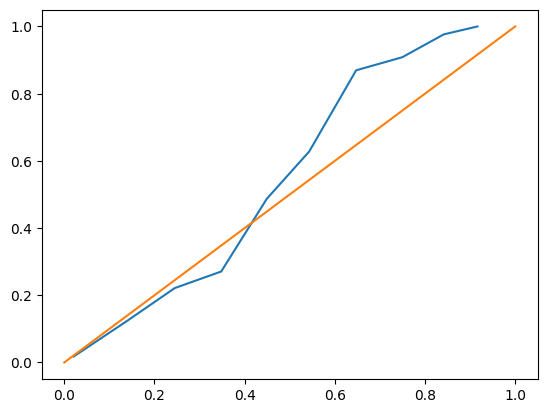

In [39]:
# TODO: Delete later 
prob_true, prob_pred = calibration_curve(y_test, prediction_probs, n_bins=10)
plt.plot(prob_pred, prob_true)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

### ROC-AUC

In [40]:
fpr, tpr, _ = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

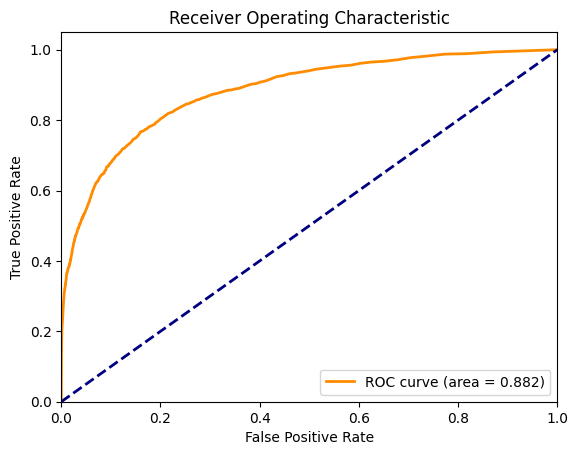

In [41]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall-AUC

In [13]:
precision, recall, _ = precision_recall_curve(y_test, prediction_probs)
pr_auc = auc(recall, precision)

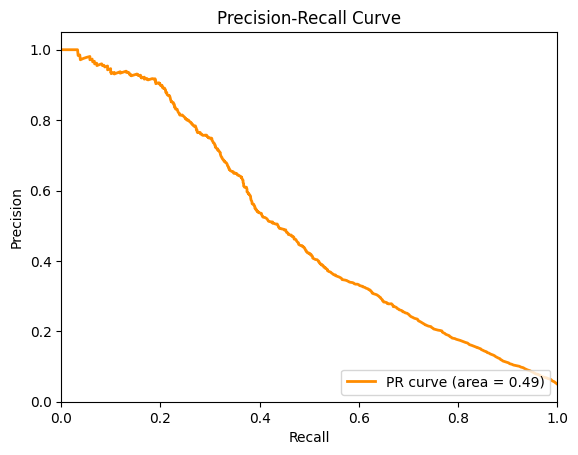

In [14]:
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [15]:
thresh_range = np.linspace(0, 1, 10001)                            
true_positives = np.array([np.count_nonzero(prediction_probs_pos >= thresh) for thresh in thresh_range])
false_positives = np.array([np.count_nonzero(prediction_probs_neg >= thresh) for thresh in thresh_range])
true_negatives = np.array([np.count_nonzero(prediction_probs_neg < thresh) for thresh in thresh_range])
false_negatives = np.array([np.count_nonzero(prediction_probs_pos < thresh) for thresh in thresh_range])

Calculate the gmean score and find its maximum on which the decision of the models threshold is based. 

In [16]:
gmeans = np.sqrt(true_positives / (true_positives + false_negatives) * true_negatives / (true_negatives + false_positives))
max_gmean = max(gmeans)
max_gmean_idx = np.argmax(gmeans)
assert max_gmean == gmeans[max_gmean_idx]
best_thresh = thresh_range[max_gmean_idx]

Calculate the performance measures for the best threshold as computed above according to the maximal gmean score.

In [17]:
sensitivity = true_positives[max_gmean_idx] / (true_positives[max_gmean_idx] + false_negatives[max_gmean_idx])
specificity = true_negatives[max_gmean_idx] / (true_negatives[max_gmean_idx] + false_positives[max_gmean_idx])
gmean = np.sqrt(sensitivity * specificity)
accuracy = (true_positives[max_gmean_idx] + true_negatives[max_gmean_idx]) / len(prediction_probs)

Cost capture

In [18]:
cc_pred = prediction_probs >= np.quantile(prediction_probs, 0.95)
cc_true = y_test == 1
cost_capture = 100 * sum(test[cc_pred]['Total_Costs_Next_Year']) / sum(test[cc_true]['Total_Costs_Next_Year'])

In [20]:
cost_capture

61.27971606255961

## Save model

In [22]:
filename = f'results/model_explanation/random_forest_python'

if overwrite:
    with open(filename + '.sav', 'wb') as handle:
        pickle.dump(model, handle)
        
    with open(filename + '_threshold.sav', 'wb') as handle:
        pickle.dump(best_thresh, handle)

### Save performance values

In [23]:
performance_values = pd.Series({'ROC AUC': roc_auc, 'PR AUC': pr_auc, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Gmean': gmean, 'Cost Capture': cost_capture})
if overwrite:
    performance_values.to_csv('results/model_explanation/random_forest_performance_python.csv')